# Data Analyzer

In [1]:
import os

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
import pandas as pd

In [4]:
import math

In [5]:
def calculate_Gflops(df):
    # GFLOPS = gigaflops per second = 1e-9 * 2*n^3 / time_in_secs
    #num_multiplies = (math.ceil((60000/df['Matrix_Size'])) * 5)
    num_epochs = 5
    num_training_examples = 60000
    df['GFLOPS'] = 10**-9 * 2*df['Matrix_Size']**3 * ((num_training_examples/df['Matrix_Size']) * num_epochs) / df['Layer_2_matmul_time']
    return df

In [6]:
def convert_us_to_seconds(df, rows):
    for row in rows: 
        df[row] = df[row] * 10**-6
    
    return df

In [7]:
onet_df = pd.read_csv('1_thread_time.csv')

In [8]:
onet_df = convert_us_to_seconds(onet_df, ['Layer_2_matmul_time', 'Total_fastmm_time'])

In [9]:
onet_df = calculate_Gflops(onet_df)

In [10]:
onet_df.head()

,Algorithm,Matrix_Size,Layer_2_matmul_time,Total_fastmm_time,GFLOPS
0,dgemm,512,5.570561,66.236897,28.235291
1,bini322,512,6.567596,76.923617,23.948855
2,schonhage333,512,6.760020,80.939220,23.267151
3,smirnov224,512,6.108837,71.998949,25.747355
4,smirnov225,512,6.599784,78.096231,23.832053


In [11]:
manyt_df = pd.read_csv('12_threads_time.csv')

In [12]:
manyt_df = convert_us_to_seconds(manyt_df, ['Layer_2_matmul_time', 'Total_fastmm_time'])

In [13]:
manyt_df = calculate_Gflops(manyt_df)

In [14]:
manyt_df.head()

,Algorithm,Matrix_Size,Layer_2_matmul_time,Total_fastmm_time,GFLOPS
0,dgemm,512,0.729191,8.044010,215.699814
1,bini322,512,3.222561,37.101161,48.807895
2,schonhage333,512,3.332613,38.848759,47.196114
3,smirnov224,512,1.610752,17.288289,97.647832
4,smirnov225,512,2.151513,24.851678,73.105017


In [15]:
# fastest algorithm at each size
def fastest_algo(df):
    matrix_sizes = [512, 1024, 2048, 4096, 8192]
    rows = []
    for size in matrix_sizes: 
        time = df[df['Matrix_Size'] == size]['Total_fastmm_time'].min()
        algo = df[df['Total_fastmm_time'] == time]['Algorithm'].iloc[0]
        if algo == 'dgemm':
            dgemm_speed_up = 'N/A'
        else:
            dgemm_time = df[(df['Matrix_Size'] == size) & (df['Algorithm'] == 'dgemm')]['Total_fastmm_time'].iloc[0]
            dgemm_speed_up = dgemm_time/ time
            
        rows.append({'Size':size, 'Fastest Algorithm': algo, 'dgemm speed up':dgemm_speed_up})
    
    print(pd.DataFrame(rows))

In [16]:
# fastest one thread algorithms
fastest_algo(onet_df)

   Size Fastest Algorithm dgemm speed up
0   512             dgemm            N/A
1  1024        smirnov442       1.099826
2  2048        smirnov442       1.184671
3  4096        smirnov444       1.271704
4  8192        smirnov444       1.274217


In [17]:
# fastest all thread algorithms
fastest_algo(manyt_df)

   Size Fastest Algorithm dgemm speed up
0   512             dgemm            N/A
1  1024             dgemm            N/A
2  2048             dgemm            N/A
3  4096        smirnov442       1.104532
4  8192        smirnov442       1.169574


In [18]:
def parallel_speedup(one_thread_df, all_thread_df, algorithm):
    matrix_sizes = [512, 1024, 2048, 4096, 8192]
    one_thread_times = []
    all_thread_times = []
    
    for size in matrix_sizes:
        one_thread_time = one_thread_df[(one_thread_df['Matrix_Size'] == size) & (one_thread_df['Algorithm'] == algorithm)]['Total_fastmm_time'].iloc[0]
        all_thread_time = all_thread_df[(all_thread_df['Matrix_Size'] == size) & (all_thread_df['Algorithm'] == algorithm)]['Total_fastmm_time'].iloc[0]
        print(f'Size: {size},      Parallel speed up: {one_thread_time/all_thread_time}')
    
    
    

In [19]:
parallel_speedup(onet_df, manyt_df, 'smirnov444')

Size: 512,      Parallel speed up: 2.7581334273140135
Size: 1024,      Parallel speed up: 4.495907981947013
Size: 2048,      Parallel speed up: 5.096510564904463
Size: 4096,      Parallel speed up: 7.329559538539906
Size: 8192,      Parallel speed up: 8.608614643301058


In [20]:
parallel_speedup(onet_df, manyt_df, 'smirnov442')

Size: 512,      Parallel speed up: 4.4497622420546525
Size: 1024,      Parallel speed up: 5.299505309743871
Size: 2048,      Parallel speed up: 5.158816844513425
Size: 4096,      Parallel speed up: 8.685848874130242
Size: 8192,      Parallel speed up: 10.514258421082426


In [21]:
parallel_speedup(onet_df, manyt_df, 'bini322')

Size: 512,      Parallel speed up: 2.0733479928694423
Size: 1024,      Parallel speed up: 4.167967321233155
Size: 2048,      Parallel speed up: 3.6078254508200196
Size: 4096,      Parallel speed up: 6.796307954054155
Size: 8192,      Parallel speed up: 6.34959507021419


In [22]:
parallel_speedup(onet_df, manyt_df, 'dgemm')

Size: 512,      Parallel speed up: 8.23431344322653
Size: 1024,      Parallel speed up: 9.376460848808883
Size: 2048,      Parallel speed up: 9.70632433973335
Size: 4096,      Parallel speed up: 9.730066372629379
Size: 8192,      Parallel speed up: 11.145055553207762


In [28]:
def time_plotter(algorithm, df):
    dgemm_times = []
    algorithm_times = []
    
    matrix_sizes = [512, 1024, 2048, 4096, 8192]
    for size in matrix_sizes:
        dgemm_times.append(df[(df['Matrix_Size'] == size) & (df['Algorithm'] == 'dgemm')]['GFLOPS'].iloc[0])
        algorithm_times.append(df[(df['Matrix_Size'] == size) & (df['Algorithm'] == algorithm)]['GFLOPS'].iloc[0])
    

    x = np.arange(len(matrix_sizes))
    width = 0.2

    plt.rcParams['figure.figsize'] = [15, 6]

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, dgemm_times, width, label='dgemm')
    rects2 = ax.bar(x + width/2, algorithm_times, width, label=algorithm)

    ax.set_ylabel('GFLOPS')
    ax.set_xlabel('Matrix size')
    ax.set_title(f'{algorithm} time vs dgemm GFLOPS')
    ax.set_xticks(x)
    ax.set_xticklabels(matrix_sizes)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()


    plt.show()

## Fastest One Thread Algorithms vs dgemm (classic matmul)

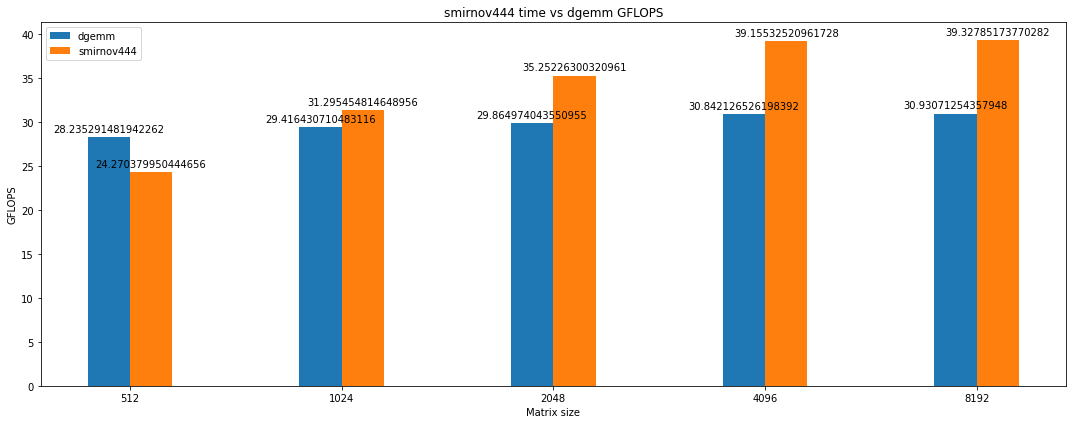

In [29]:
time_plotter(algorithm='smirnov444', df=onet_df)

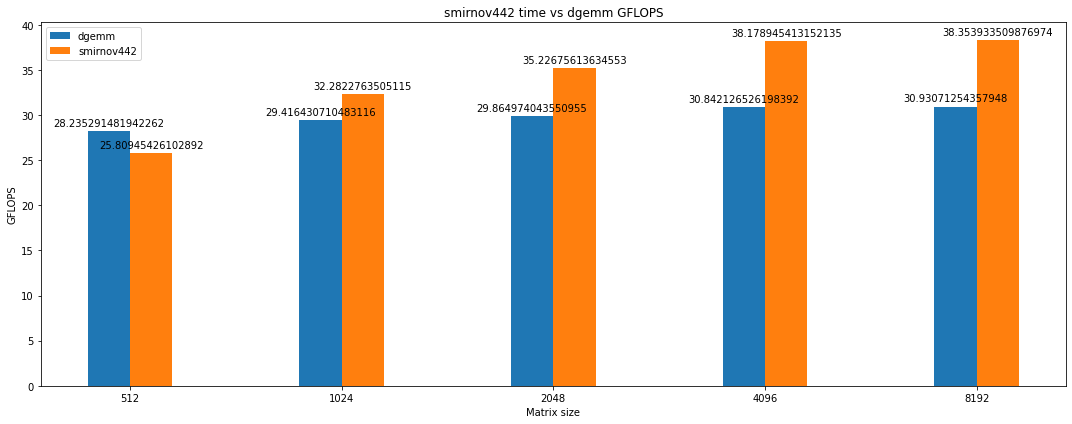

In [30]:
time_plotter(algorithm='smirnov442', df=onet_df)

## 12 Threads times

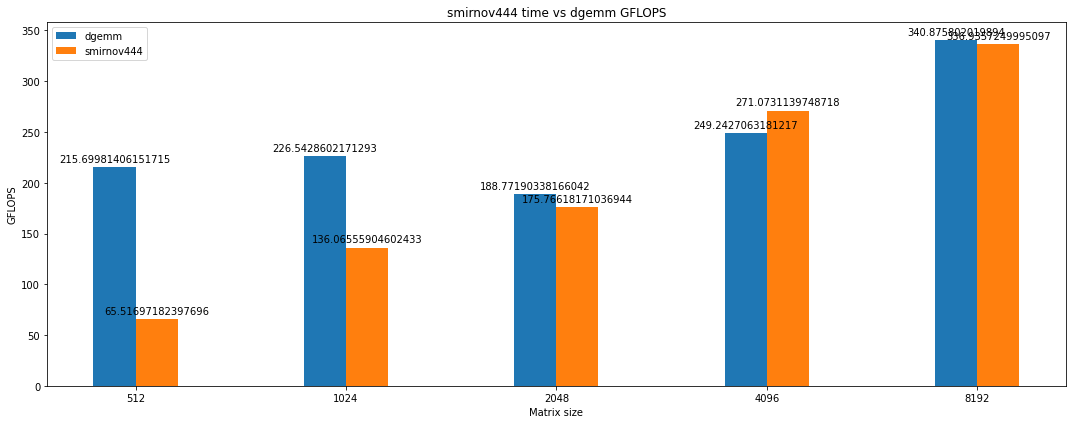

In [31]:
time_plotter(algorithm='smirnov444', df=manyt_df)

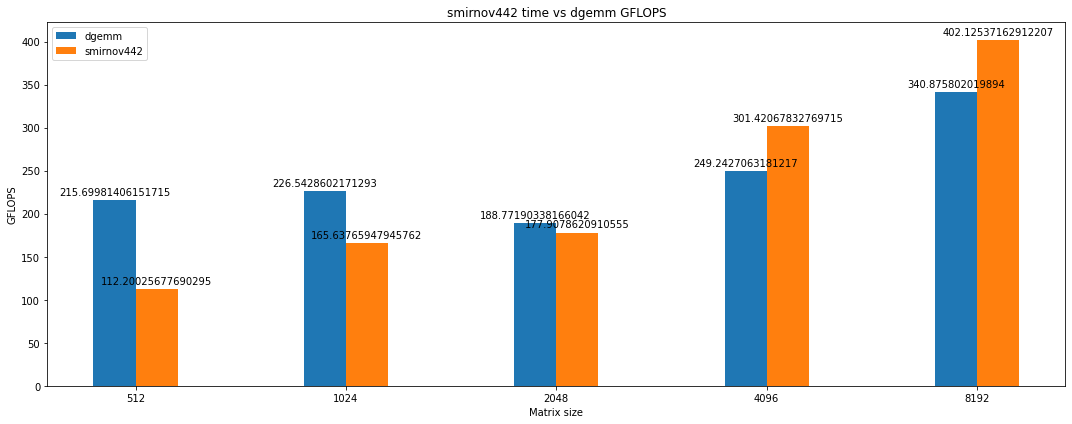

In [32]:
time_plotter(algorithm='smirnov442', df=manyt_df)